##### EXERCÍCIO AVALIATIVO 04: Caixeiro Viajante

In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
@jit(nopython=True)
def distances(N,x,y):
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))        
    return dist

In [3]:
@jit(nopython=True)
def get_cost(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    # conecta a ufaltima e a primeira cidades do caminho
    ener += dist[path[0],path[N-1]]
    return ener

In [4]:
@jit(nopython=True)
def newpath(N,path):
    # define uma nova caminhada
    newpath = np.zeros(N,dtype=np.int16)
    # escolhe uma posicao aleatoria da caminhada
    i=np.random.randint(N)   
    j=i
    while j==i:
        # escolhe outra posicao
        j=np.random.randint(N)
        # ordena os indices
        if i>j:                    
            ini = j
            fin = i
        else:
            ini = i
            fin = j
    
    # inverte o sentido em que percorre o caminho entre os indices escolhidos
    for k in range(N):    
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]
    
    return newpath,ini,fin

In [5]:
@jit(nopython=True)
def mc_step(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)
      
    np1,ini,fin = newpath(N,path) # propoe um novo caminho
      
    # determina a diferenca de energia 
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]
    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado at\'e9 o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
              
    return en,path,best_e,best_p

**Avaliação dos caminhos**

In [30]:
N = 5
t = 10
BASE = 0.5
threshold = 0.0005

In [31]:
rng = np.random.default_rng(seed=42)
x=rng.random(N)
y=rng.random(N)

pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
     pathini[i]=i

In [32]:
dist_matrix = distances(N, x, y)

In [33]:
temperatures = []
paths = []
costs = []

path = pathini
cost = get_cost(N, pathini, dist_matrix)
best_e = cost
best_p = path

n_steps = 0

while t > threshold:
    cost, path, best_e, best_p = mc_step(N, t, cost, path, best_e, best_p, dist_matrix)
    
    costs.append(best_e)
    paths.append(path)
    temperatures.append(t)
    t = t * BASE
    n_steps += 1

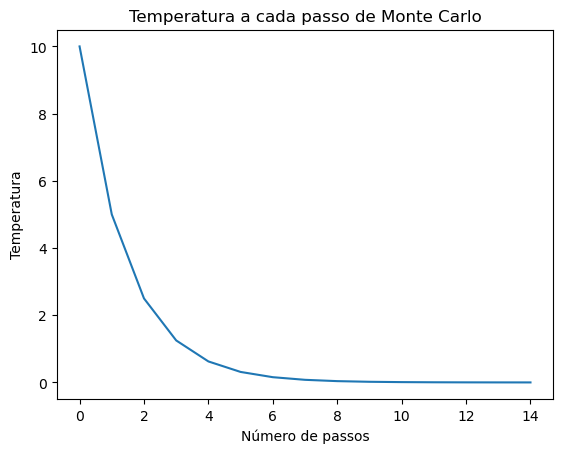

In [34]:
plt.plot(temperatures)
plt.title("Temperatura a cada passo de Monte Carlo")
plt.xlabel("Número de passos")
plt.ylabel("Temperatura")
plt.show()

**Plot do primeiro e último caminhos**

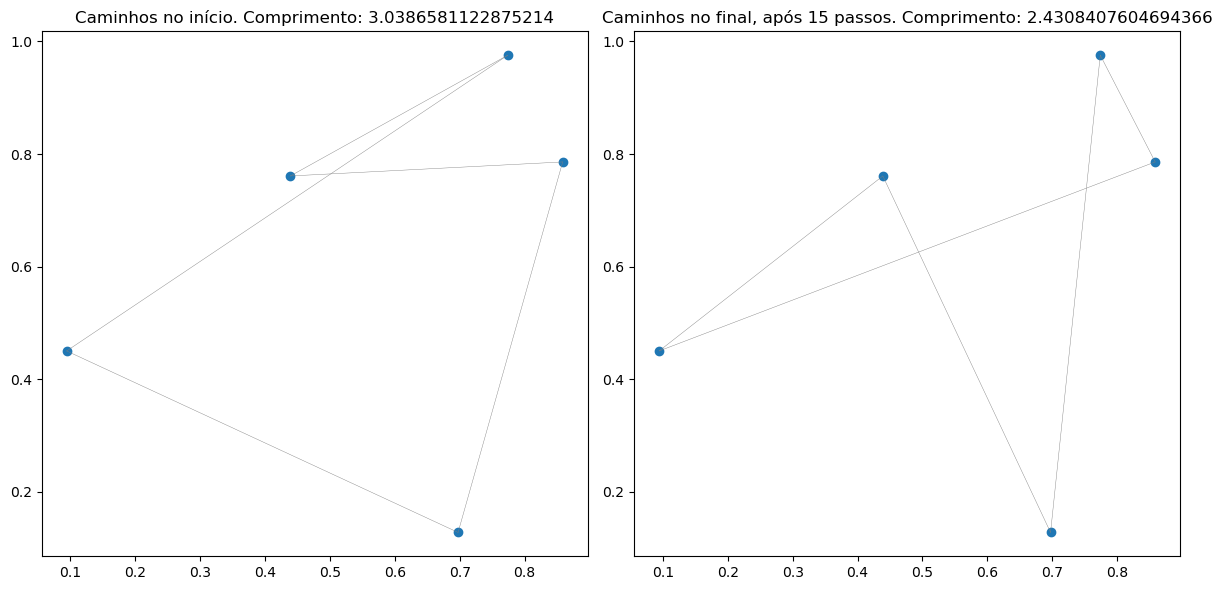

In [35]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

path = paths[0]
cost = costs[0]

ax1.plot(x, y, "o")
for i in range(N):
        ax1.plot(
            [x[path[i]], x[path[(i + 1) % N]]],
            [y[path[i]], y[path[(i + 1) % N]]],
            color='gray', linewidth=0.3
        )
ax1.set_title(f'Caminhos no início. Comprimento: {cost}')

path = paths[-1]
cost = costs[-1]

ax2.plot(x, y, "o")
for i in range(N):
        ax2.plot(
            [x[path[i]], x[path[(i + 1) % N]]],
            [y[path[i]], y[path[(i + 1) % N]]],
            color='gray', linewidth=0.3
        )
ax2.set_title(f'Caminhos no final, após {n_steps} passos. Comprimento: {cost}')

plt.tight_layout()
plt.show()